# Brain Tumor Detection using Convolutional Neural Networks

## Setting up Enviroment

The following are necessary packages for running this notebook.

In [1]:
import os
import pathlib
import cv2
import imutils

### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#all library needed for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers,regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19, DenseNet201, DenseNet121

from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot import confusion_matrix as cm
# from sklearn.model_selection import train_test_split, GroupShuffleSplit
# from skimage.transform import resize
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Processing

#### The data for this notebook can be found at https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

Below we will prepare the data for testing.

### Cropping Data to be Standardized using Contours
We will be using the contouring concept covered in this article: https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/. 

In [3]:
def crop_brain_contour(image):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out using the extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    

    return new_image

In [4]:
# Gets image paths. data_path = path to directory containing images
def getImagePaths(data_path):
    paths = []
    for r, _, f in os.walk(f'{data_path}'):
        for file in f:
            if not file.startswith('.'):
                paths.append(os.path.join(r, file))
    return paths

# Reads, crops, and resizes images and returns X and y values.
def populateXandY(paths, img_size=(100, 100)):
    X = []
    y = []
    for i, imagePaths in enumerate(paths):
        for image in imagePaths:
            img = cv2.imread(image)
#             img = crop_brain_contour(img)
            img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
            X.append(img)
            y.append(i)
    return np.array(X), np.array(y).reshape((-1, 1))

def get_X_and_y(data_path):
    # Load folders Yes and No separately.
    yes_paths = getImagePaths(f'{data_path}yes')
    no_paths = getImagePaths(f'{data_path}no')
    
    # Note: Ordering matters since we let enumerate create classes above.
    # Returns X, y
    return populateXandY([no_paths, yes_paths], img_size=(100, 100))

In [5]:
# Assuming these path exists in CWD
data_path = "./Br35H/"

# Note: Ordering matters since we let enumerate create classes above.
X, y = get_X_and_y(data_path)
print(f'Number of Yes: {y[y==1].shape[0]}\nNumber of No: {y[y==0].shape[0]}')

X.shape, y.shape

Number of Yes: 1500
Number of No: 1500


((3000, 100, 100, 3), (3000, 1))

This dataset is balanced so splitting can be performed normally.

### Splitting the data

Below we split the data using the splitting algorithm from A3 in CS445.

The data will be split into 60% training, 20% testing, and 20% validation sets

In [6]:
# Splits the data into train, test, and validation sets.
def train_test_validation(X, y, randSeed=None):
    # If random seed is given, set seed.
    if randSeed:
        np.random.seed(randSeed)
    
    # Randomly order X and T
    randorder = np.arange(X.shape[0])
    np.random.shuffle(randorder)
    X = X[randorder, :]
    y = y[randorder, :]
    
    n_folds = 5
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds 
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  # handles case when n_samples not evenly divided by n_folds

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], y[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], y[start: ,]) )
    
    X_validate, T_validate = folds[0]
    X_test, T_test = folds[1]
    X_train, T_train = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    return X_train, T_train, X_test, T_test, X_validate, T_validate

# Calls train_test_validation and converts targets to categorical
def get_train_test_validation(X, y, randSeed=None):
    X_train, T_train, X_test, T_test, X_validate, T_validate = train_test_validation(X, y, randSeed=randSeed)
    T_train = to_categorical(T_train)
    T_test = to_categorical(T_test)
    T_validate = to_categorical(T_validate)
    
    return X_train, T_train, X_test, T_test, X_validate, T_validate

In [7]:
# Note: Running with random seed 42. Leave randSeed empty or randSeed=None if no seed.
X_train, T_train, X_test, T_test, X_validate, T_validate = get_train_test_validation(X, y, randSeed=42)

X_train.shape, T_train.shape, X_test.shape, T_test.shape, X_validate.shape, T_validate.shape

((1800, 100, 100, 3),
 (1800, 2),
 (600, 100, 100, 3),
 (600, 2),
 (600, 100, 100, 3),
 (600, 2))

## Lets Visualize Our Data

Below we will preview the first 50 elements in the training set.

In [8]:
# Plots n elements (10 per row) and whether the image is a tumor or not.
def plot_sample_images(X, y, n=50):
    columns_n = 10
    rows_n = int(np.ceil(n / columns_n))
    
    plt.figure(figsize=(20, 16))
    
    for i in range(n):
        plt.subplot(rows_n, columns_n, i + 1)
        plt.imshow(X[i])
        plt.title("Yes" if y[i][1] == 1 else "No", fontsize='x-large')
        plt.axis('off')
    plt.show()

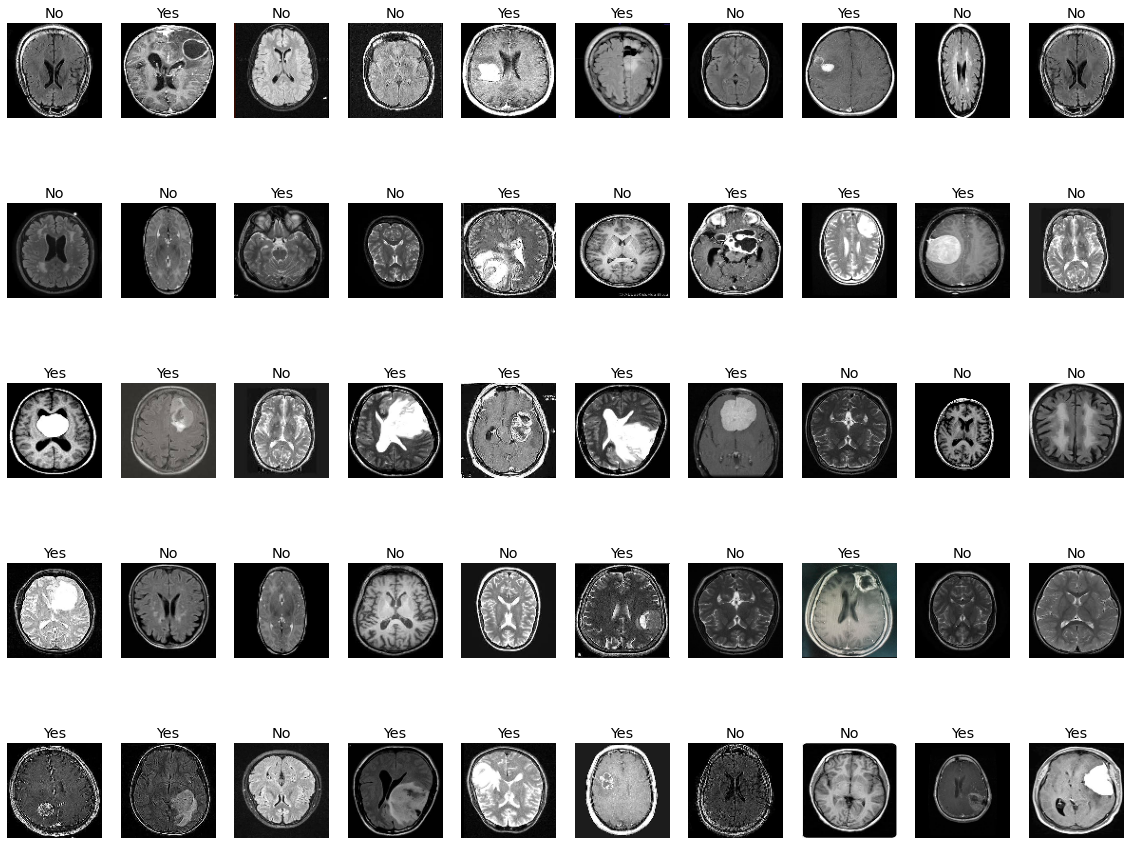

In [9]:
plot_sample_images(X_train, T_train)

# Training Model for Br35H Brain Tumor Detection 2020 Dataset

https://www.kaggle.com/ahmedhamada0/brain-tumor-detection


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

def getModel():
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(100,100,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='binary_crossentropy',
      optimizer='adam', metrics=['accuracy'])
    return model


In [11]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 64)       256       
 hNormalization)                                                 
                                                        

In [12]:
# earlystop = EarlyStopping(monitor='val_loss')
earlystop = EarlyStopping(patience = 5)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [13]:
# Without weight
history = model.fit(X_train, T_train , epochs = 50,
                    validation_data=(X_test, T_test),
                    callbacks = callbacks
                   )

Epoch 1/50
57/57 [==============================] - 36s 606ms/step - loss: 0.4907 - accuracy: 0.8206 - val_loss: 0.4691 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - 33s 586ms/step - loss: 0.2171 - accuracy: 0.9183 - val_loss: 0.4228 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - 33s 581ms/step - loss: 0.1039 - accuracy: 0.9639 - val_loss: 0.1861 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 4/50
57/57 [==============================] - 33s 582ms/step - loss: 0.0641 - accuracy: 0.9800 - val_loss: 0.3885 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 5/50
57/57 [==============================] - 34s 591ms/step - loss: 0.0465 - accuracy: 0.9878 - val_loss: 0.0945 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 6/50
57/57 [==============================] - 33s 586ms/step - loss: 0.0267 - accuracy: 0.9928 - val_loss: 0.0776 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 7/50
57/57 [==============================] - ETA: 0s - lo

In [14]:
def plot_history(history):    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc)
    plt.plot(x, val_acc)
    plt.title('Accuracy vs. No. of epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(x, loss)
    plt.plot(x, val_loss)
    plt.title('Loss vs. No. of epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    plt.show()

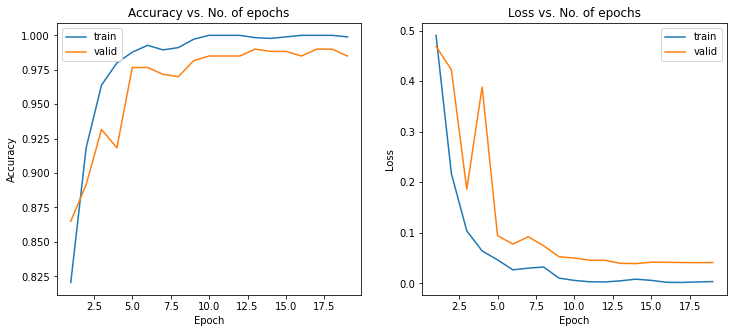

In [15]:
plot_history(history)

In [16]:
def getAccuracyUsingPred(y, y_pred):
    return round((y[y_pred[:,0]==y[:,0]].shape[0] / y.shape[0]) * 100, 2)

# Predicts training, testing, and validation sets and prints accuracies
def predictions(model, X_train, T_train, X_test, T_test, X_validate, T_validate):
    train_pred = model.predict(X_train).round()
    test_pred = model.predict(X_test).round()
    validate_pred = model.predict(X_validate).round()
    
    print(f'Training Accuracy:\t{getAccuracyUsingPred(T_train, train_pred)}%')
    print(f'Testing Accuracy:\t{getAccuracyUsingPred(T_test, test_pred)}%')
    print(f'Validation Accuracy:\t{getAccuracyUsingPred(T_validate, validate_pred)}%')
    
    return train_pred, test_pred, validate_pred

In [17]:
train_pred, test_pred, validate_pred = predictions(model, X_train, T_train, X_test,
                                                   T_test, X_validate, T_validate)

Training Accuracy:	100.0%
Testing Accuracy:	98.5%
Validation Accuracy:	97.17%


In [18]:
def getConfusionMatrix(y, y_pred):
    # np.argmax() undoes to_categorical method.
    matrix = confusion_matrix(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))
    disp=cm.ConfusionMatrixDisplay(confusion_matrix = matrix,
                               display_labels=['No', 'Yes'])
    return disp

def graphConfusionMatrix(listOfMatrixDisp, listOfLabels):
    fig, ax = plt.subplots(1, len(listOfMatrixDisp), figsize=(20,5))
    colors = [plt.cm.Blues, plt.cm.BuGn, plt.cm.GnBu]
    
    if len(listOfMatrixDisp) == 1:
        disp = listOfMatrixDisp[0]
        disp.plot(ax=ax, cmap=colors[0])
        disp.ax_.set_title(listOfLabels[0])
    else:
        for i, disp in enumerate(listOfMatrixDisp):
            disp.plot(ax=ax[i], cmap=colors[i % 3])
            disp.ax_.set_title(listOfLabels[i])

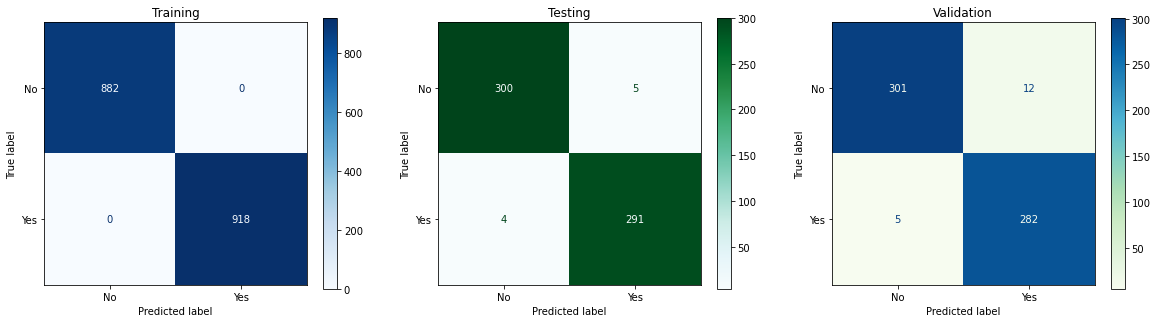

In [19]:
train_cf = getConfusionMatrix(T_train, train_pred)
test_cf = getConfusionMatrix(T_test, test_pred)
validate_cf = getConfusionMatrix(T_validate, validate_pred)

graphConfusionMatrix([train_cf, test_cf, validate_cf], ['Training', 'Testing', 'Validation'])

Looking at these confusion matrixes, we can see there are less false negatives than false positives (model predicting no tumor when there is a tumor) in the Testing and Validation sets. 

To see why this may be the case, below we will look at the images that the model is confused on.

In [20]:
# Gets indexes of incorrectly classified images in a set
def getIncorrectImages(y, y_pred):
    return np.where(np.argmax(y, axis=1) != np.argmax(y_pred, axis=1))

def getWrongXandY(X_train, T_train, train_pred, X_test, T_test, test_pred, X_validate, T_validate, validate_pred):
    # Combines all incorrectly classified images into a single array
    wrongIndices = getIncorrectImages(T_train, train_pred)
    wrong_X = X_train[wrongIndices]
    wrong_y = T_train[wrongIndices]

    wrongIndices = getIncorrectImages(T_test, test_pred)
    wrong_X = np.vstack((wrong_X, X_test[wrongIndices]))
    wrong_y = np.vstack((wrong_y, T_test[wrongIndices]))

    wrongIndices = getIncorrectImages(T_validate, validate_pred)
    wrong_X = np.vstack((wrong_X, X_validate[wrongIndices]))
    wrong_y = np.vstack((wrong_y, T_validate[wrongIndices]))

    return wrong_X, wrong_y

In [21]:
wrong_X, wrong_y = getWrongXandY(X_train, T_train, train_pred, X_test, T_test, test_pred, X_validate, T_validate, validate_pred)
wrong_X.shape, wrong_y.shape

((26, 100, 100, 3), (26, 2))

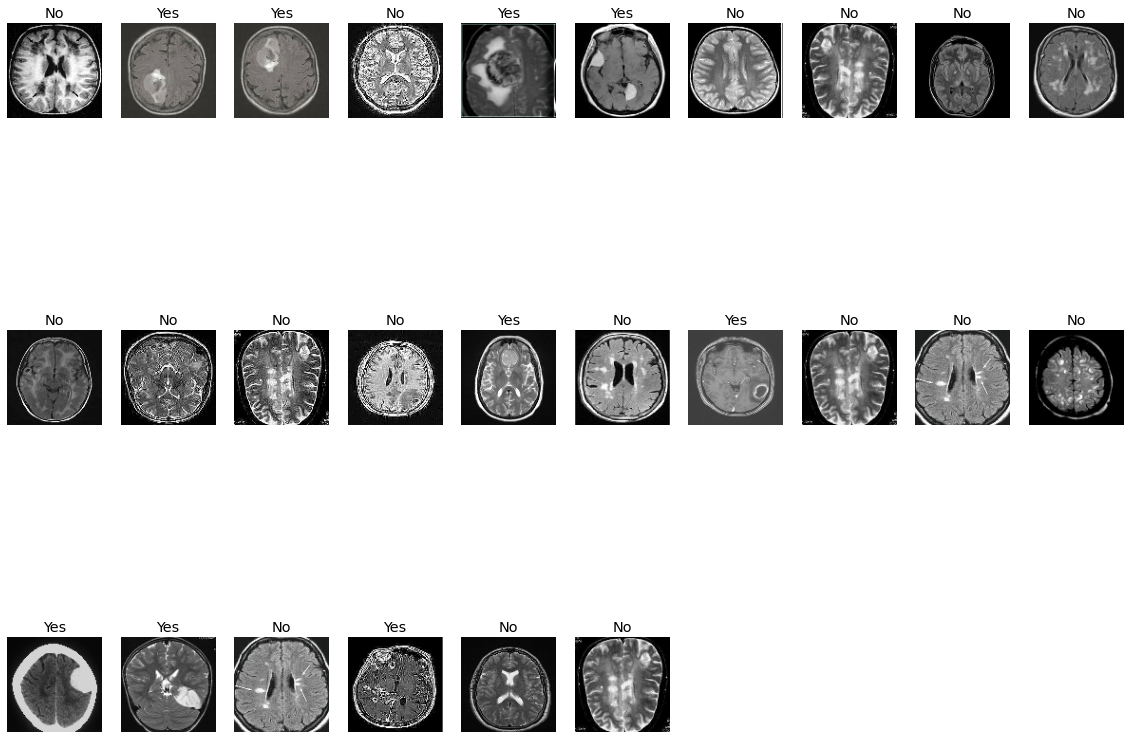

In [22]:
plot_sample_images(wrong_X, wrong_y, n=wrong_X.shape[0])

## IMPORTANT: Recall that the images above are classified incorrectly.

Images with labels 'Yes' are actually images that do NOT have a tumor and images with labels 'No' are images that DO contain tumors.

## Results BR35H

From our CNN model, we were able to achieve ~ 95% accuracy on training and validation sets. 

When we display the incorrectly classified brain tumors, many of the false positive images contain small bright spheres which confuses our model. On the other hand, false negative images generally have little to no bright areas that stand out. 


# Training Model for Brain MRI Images for Brain Tumor Detection Dataset

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


In [23]:
data_path = "./data/brain_tumor_dataset/"

# Let s indicates 'smaller' file (dataset above)
Xs, ys = get_X_and_y(data_path)

print(f'Number of Yes: {ys[ys==1].shape[0]}\nNumber of No: {ys[ys==0].shape[0]}')
Xs.shape, ys.shape

Number of Yes: 155
Number of No: 98


((253, 100, 100, 3), (253, 1))

### This dataset is imbalanced:

This dataset has 61% brain tumor images and 39% non-brain tumor images. 

Since this dataset only contains 253 samples, we will be randomly resample the 'No' images to match the number of 'Yes' images. In other words, we will be oversampling the 'No' dataset before splitting the data. 

In [24]:
# Gets random indexes from 'No' dataset
random_no_indexes = np.random.choice(np.where(ys==0)[0], size=57, replace=False)
resampled_no = Xs[random_no_indexes]

Xs = np.vstack((resampled_no, Xs))
ys = np.vstack((np.zeros(57).reshape((-1, 1)), ys))

print(f'Number of Yes: {ys[ys==1].shape[0]}\nNumber of No: {ys[ys==0].shape[0]}')
Xs.shape, ys.shape

Number of Yes: 155
Number of No: 155


((310, 100, 100, 3), (310, 1))

In [25]:
Xs_train, Ts_train, Xs_test, Ts_test, Xs_validate, Ts_validate = get_train_test_validation(Xs, ys, randSeed=42)

Xs_train.shape, Ts_train.shape, Xs_test.shape, Ts_test.shape, Xs_validate.shape, Ts_validate.shape

((186, 100, 100, 3),
 (186, 2),
 (62, 100, 100, 3),
 (62, 2),
 (62, 100, 100, 3),
 (62, 2))

### Visualizing this dataset

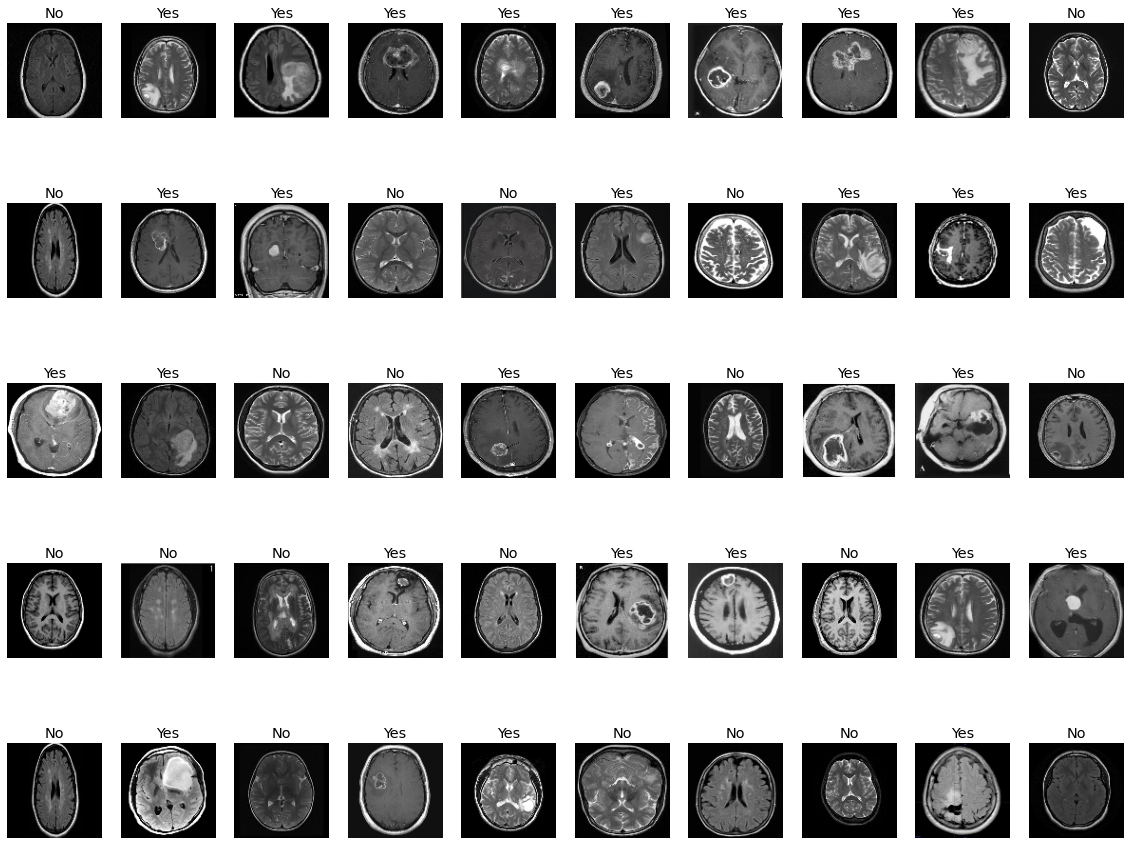

In [26]:
plot_sample_images(Xs_train, Ts_train)

## Modeling

In [27]:
model_s = getModel()
model_s.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 98, 98, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 47, 47, 64)       256       
 hNormalization)                                                 
                                                      

In [28]:
# callbacks already initialized above -- These are just reminders

# earlystop = EarlyStopping(monitor='val_loss')
# # earlystop = EarlyStopping(patience = 10)
# learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
# callbacks = [earlystop,learning_rate_reduction]

In [29]:
history_s = model_s.fit(Xs_train, Ts_train , epochs = 50,
                    validation_data=(Xs_test, Ts_test),
                    callbacks = callbacks
                   )

Epoch 1/50
6/6 [==============================] - 4s 586ms/step - loss: 1.0283 - accuracy: 0.7097 - val_loss: 2.1160 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 3s 555ms/step - loss: 0.2444 - accuracy: 0.9140 - val_loss: 6.3811 - val_accuracy: 0.4355 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9516
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 [==============================] - 4s 608ms/step - loss: 0.1759 - accuracy: 0.9516 - val_loss: 3.5666 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 3s 576ms/step - loss: 0.1247 - accuracy: 0.9731 - val_loss: 2.0156 - val_accuracy: 0.5645 - lr: 5.0000e-04
Epoch 5/50
6/6 [==============================] - 3s 534ms/step - loss: 0.0829 - accuracy: 1.0000 - val_loss: 1.4285 - val_accuracy: 0.7097 - lr: 5.0000e-04
Epoch 6/50
6/6 [==============================] - 3s 546ms/step - loss

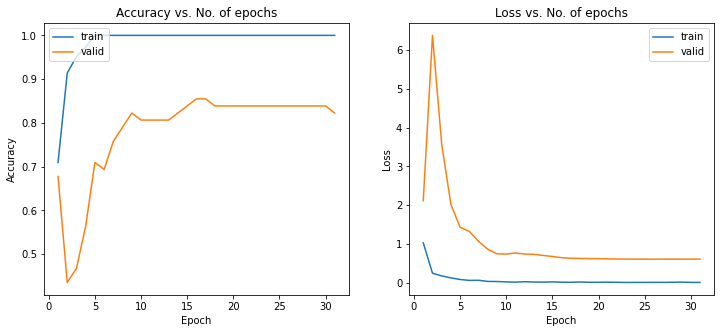

In [30]:
plot_history(history_s)

In [31]:
train_pred_s, test_pred_s, validate_pred_s = predictions(model_s, Xs_train, Ts_train, Xs_test,
                                                         Ts_test, Xs_validate, Ts_validate)

Training Accuracy:	100.0%
Testing Accuracy:	82.26%
Validation Accuracy:	91.94%


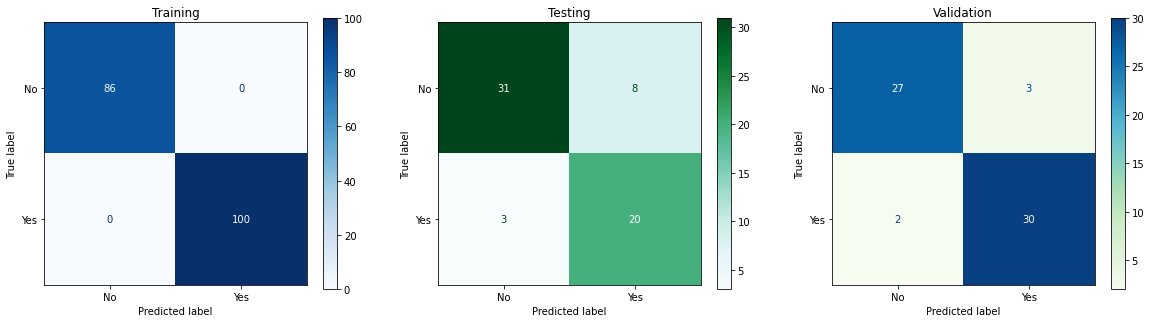

In [32]:
train_cf_s = getConfusionMatrix(Ts_train, train_pred_s)
test_cf_s = getConfusionMatrix(Ts_test, test_pred_s)
validate_cf_s = getConfusionMatrix(Ts_validate, validate_pred_s)

graphConfusionMatrix([train_cf_s, test_cf_s, validate_cf_s], ['Training', 'Testing', 'Validation'])

Similar to the Br35H Dataset, this model contains less false negative values than false positive values. This is not ideal for medical related predictions.

Again, we will take a look at the images that are confusing the model.

## Recall: The images below are the incorrectly classified images. 'Yes' means the true value is 'No' and vise versa.

In [33]:
wrong_Xs, wrong_ys = getWrongXandY(Xs_train, Ts_train, train_pred_s, Xs_test, Ts_test, test_pred_s, Xs_validate, Ts_validate, validate_pred_s)
wrong_Xs.shape, wrong_ys.shape

((16, 100, 100, 3), (16, 2))

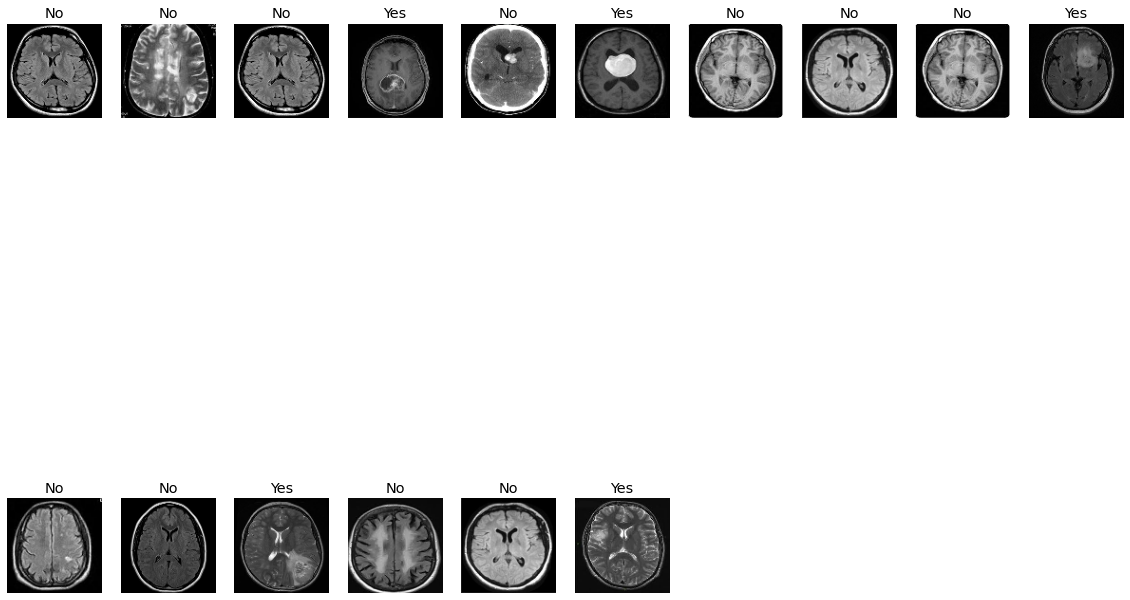

In [34]:
plot_sample_images(wrong_Xs, wrong_ys, n=wrong_Xs.shape[0])

## Results Brain MRI Dataset

Based on this model, there is on average a 75-80% accuracy when predicting images (likely due to the lack of training data). This model has a inconsistent range of accuracy since we had to resample (oversample) the 'No' dataset (see above).

Just like the BR35H dataset, however, similar patterns can be seen in incorrectly classified images (false positives contain white spheres in the MRI and false negatives don't contain these. This may indicate the models are only looking for this characteristic to classify on. 

# Cross Evaluations

### Using Br35H model on Brain MRI dataset

In [35]:
BR35H_train_pred, BR35H_test_pred, BR35H_validate_pred = predictions(model, Xs_train, Ts_train, Xs_test,
                                                                     Ts_test, Xs_validate, Ts_validate)

Training Accuracy:	98.39%
Testing Accuracy:	100.0%
Validation Accuracy:	100.0%


In [36]:
# Testing on entire dataset (Average)
BR35H_pred = model.predict(Xs).round()
print(f'Accuracy:\t{getAccuracyUsingPred(to_categorical(ys), BR35H_pred)}%')

Accuracy:	99.03%


### Using Brain MRI model on Br35H dataset

In [37]:
BMRI_train_pred, BMRI_test_pred, BMRI_validate_pred = predictions(model_s, X_train, T_train, X_test, T_test, X_validate, T_validate)

Training Accuracy:	80.72%
Testing Accuracy:	83.17%
Validation Accuracy:	80.0%


In [38]:
# Testing on entire dataset (Average)
BMRI_pred = model_s.predict(X).round()
print(f'Accuracy:\t{getAccuracyUsingPred(to_categorical(y), BMRI_pred)}%')

Accuracy:	81.07%


### Comparing Confusion Matrix of Both

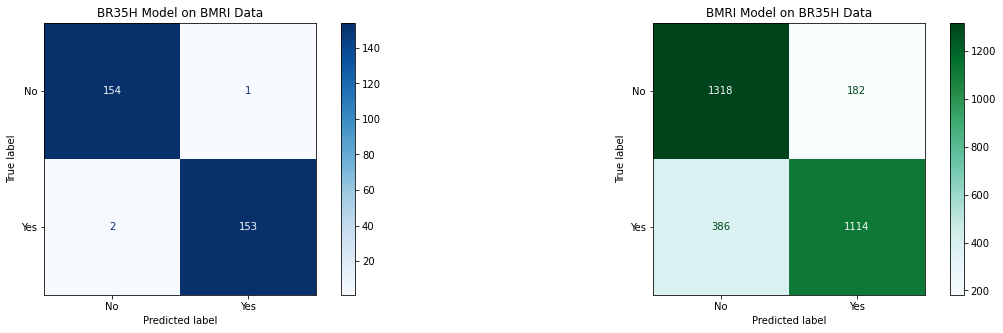

In [39]:
BR35H_cf = getConfusionMatrix(to_categorical(ys), BR35H_pred)
BMRI_cf = getConfusionMatrix(to_categorical(y), BMRI_pred)

graphConfusionMatrix([BR35H_cf, BMRI_cf], ['BR35H Model on BMRI Data', 'BMRI Model on BR35H Data'])

# Results

The Brain MRI dataset overall performs worse than Br35H dataset. This likely due to quantity of data and the imbalance between 'Yes' and 'No'. Interestingly enough, however, using this dataset's model to predict images in Br35H dataset achived an accuracy of \~75-80%. This is remarkably high considering it is achieving this accuracy on 3000 unseen data (\~20x the size of the Brain MRI dataset). However, due to the high false negative rates, this model should never be used for predicting brain tumors.

The Br35H dataset achieves up to an ~95-99% accuracy on its testing and validation sets and suprisingly also had similar accuracy when cross evaluating on the Brain MRI dataset. This may indicate that the data seen in the Brain MRI dataset is included within the Br35H dataset since the Br35H dataset was published 3 years after the other.